In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

menu_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

menu_retriever = menu_db.as_retriever(
    search_kwargs={'k': 2}
)

query = "시그너처 스테이크의 가격과 특징은 무엇인가요?"
docs = menu_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


검색 결과: 2개


In [5]:
wine_db = Chroma(
    embedding_function=embeddings_model,
    collection_name="restaurant_wine",
    persist_directory="./chroma_db",
)

menu_retriever = wine_db.as_retriever(
    search_kwargs={'k': 2}
)

query = "스테이크와 어울리는 와인은 추천해 주세요?"
docs = menu_retriever.invoke(query)
print(f"검색 결과: {len(docs)}개")


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


검색 결과: 2개


In [6]:
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class GraphState(MessagesState):
    # messages 키를 기본적으로 제공
    documents: List[Document]
    grade: float
    num_generation: int
        

In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = menu_db.as_retriever(
    search_kwargs={"k": 2}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

제공된 메뉴에는 채식주의자를 위한 옵션이 포함되어 있지 않습니다. 하지만, 일반적으로 채식주의자를 위한 메뉴는 신선한 채소, 곡물, 콩류, 아보카도 등을 활용한 샐러드, 스프, 또는 채소 기반의 요리가 포함될 수 있습니다. 만약 다른 메뉴가 있다면, 그 중에서 채식 옵션을 선택하는 것이 좋습니다. 추가적인 메뉴가 필요하다면 말씀해 주세요!


In [8]:
from langchain_core.messages import HumanMessage, AIMessage

# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    last_human_message = state['messages'][-1]
    
    # HumanMessage 객체의 content 속성에 접근
    query = last_human_message.content
    
    # 문서 검색
    retrieved_docs = retriever.invoke(query)
    
    # 응답 생성
    response = rag_chain.invoke(query)
    
    # 검색된 문서와 응답을 상태에 저장
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

In [9]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    messages = state['messages']
    question = messages[-2].content
    answer = messages[-1].content
    context = format_docs(state['documents'])

    grading_system = """You are an expert grader. 
    Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
    
    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 횟수를 증가 
    num_generation = state.get('num_generation', 0)
    num_generation += 1
    
    return {"grade": grade_response.score, "num_generation": num_generation}

In [10]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADTING---")
    print("Grade Score: ", state["grade"])

    # 답변 생성 횟수가 3회 이상이면 "generate"를 반환
    if state["num_generation"] > 2: 
        return "generate"    
    
    # 답변 품질 평가점수가 0.7 미만이면 RAG 체인을 다시 실행 
    if state["grade"] < 0.7:  
        return "retrieve_and_respond"
    else:
        return "generate"

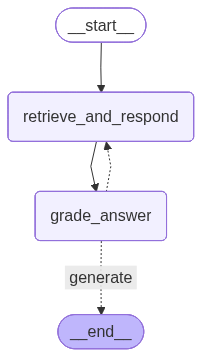

In [12]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from IPython.display import Image, display

# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
# 초기 상태
initial_state = {
    "messages": [HumanMessage(content="랭그래프를 잘하는 방법을 추천해주세요.")],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

----GRADTING---
Grade Score:  0.0
----GRADTING---
Grade Score:  1.0
최종 상태: {'messages': [HumanMessage(content='랭그래프를 잘하는 방법을 추천해주세요.', additional_kwargs={}, response_metadata={}, id='74f98278-aedb-4eb3-b208-f42fe0247fcd'), AIMessage(content='랭그래프를 잘하는 방법에는 몇 가지 팁이 있습니다:\n\n1. **기본 개념 이해**: 랭그래프의 기본 개념과 동작 방식을 충분히 이해하세요. 노드, 엣지, 그래프의 종류(유향 그래프, 무향 그래프 등)에 대해 알아보세요.\n\n2. **자료구조 연습**: 그래프를 구현하기 위해 필요한 자료구조(인접 리스트, 인접 행렬 등)를 연습해보세요. 각 자료구조의 장단점을 이해하고, 상황에 맞게 사용할 수 있어야 합니다.\n\n3. **알고리즘 학습**: 그래프 탐색 알고리즘(DFS, BFS), 최단 경로 알고리즘(Dijkstra, Bellman-Ford), 최소 신장 트리(Kruskal, Prim) 등 주요 알고리즘을 학습하고, 그 원리를 이해하세요.\n\n4. **문제 풀이**: 다양한 문제를 풀어보세요. LeetCode, HackerRank, Codeforces 등에서 그래프 관련 문제를 찾아 풀어보는 것이 좋습니다. 여러 가지 유형의 문제를 풀면서 경험을 쌓아보세요.\n\n5. **시각화**: 그래프를 시각적으로 표현해보세요. 직접 그려보거나, 온라인 도구를 사용하여 그래프의 구조를 시각화하면 이해하는 데 도움이 됩니다.\n\n6. **복잡도 분석**: 알고리즘의 시간 복잡도와 공간 복잡도를 분석해보세요. 이는 최적의 알고리즘을 선택하는 데 중요합니다.\n\n7. **커뮤니티 참여**: 프로그래밍 커뮤니티나 포럼에 참여하여 다른 사람들과 문제를 논의하고, 다양한 접근 방식을 배워보세요.\n\n8. **복습 및 지속적인 학습**: 그래프 